# Multi-Touch Attribution with LSTM-Attention Deep Learning Model
### Based on the paper "Deep Neural Net with Attention for Multi-channel Multi-touch Attribution" by Ning li, Sai Kumar Arava, Chen Dong, Zhenyu Yan, Abhishek Pani
implemented by Greg Murray

 https://arxiv.org/abs/1809.02230


## Foreword
I arrived at the idea of using an LSTM-Attenion model for MTA independently and upon googling the topic came upon the Li-Arava paper that veered from my theorized approach only minorly. The following is a description and physical implementation of the model based on the description in the paper.

## TLDR Results Summary

 This notebook contains a *quick-and-dirty*, prototype implementation of the deep learning model with attention weight vectors (**DLAW**), based on the 2018 Adobe paper in the link above, as a means of attributing channels' revenue from multi-touch impression data. The model performs much better on a simple, simulated dataset than the naive approaches 50-50 split, and first/last touched. 
 The data was simulated with an additive, mostly linear data generating function (see below for function and simulation methodology). The attribution percentage *mean absolute error* (MAE) for all approaches changed depending on the particular values chosen for the channel parameters in the simulated conversion logistic function (ie: the impact Facebook has as the second channel to impress, amount of boosting effect that a last-touched impression receives, etc.)   
 
 ### 95% Confidence Interval Absolute Error (AE), (*AE in range  [0, 1]*)

 ####  50/50 split test MAE range from 0.20-0.47 
 - (error depends entirely on how close the true attribution pct is to 50/50)
 
####  Last-Touched test MAE range from .60-.70
####  First-Touched test MAE range from .80-1
#### * **DLAW test MAE range from .12-.26**



## Simulation Methodology

### * Since the Li-Arava paper does not use a simulation or provide their data, and there was very minimal literature found on simulating MTA processes, a simulation had to be devised from scratch based on my own premises and assumptions.


The simulated data set included 100k observations with arbitrarily chosen beta coefficients and other parameters. The datset was split into 70k training obsbervations and 30k test observations. 

The data generating process (DGP) that leads to a conversion in this simple simulation is assumed to be a mostly linear process so as to make quantifying the contributions of each channel much easier, however more complex DGP's can and should be tested. To facilitate the the simulation and modeling effort, all observations were limited to exactly 2 impressions, where the channel in each time step was chosen from 3 possible channels (arbitrarily named Facebook, Google, and Snapchat). To simulate a conversion, a logistic equation is used wherein the contribution of each channel has a linear "strength" (beta) for each timestep. For example, if Facebook is seen in the first timestep then the effect is beta1_FB, and if it is seen in the second timestep then beta2_FB is used. In addition, the amount of time that elapses from the first timestep to the second decays exponentially weakening that channel's contribution to the conversion process. Also, the control variable of gender is added as an non-interactive term wherein a small additional amount is added to the conversion process independent on channel - this is less to do with what may be the case in reality and more as a means of inserting a control variable for the model to have to deal with. Lastly, relatively large, homoskedastic, Gaussian noise is added that frequently has a majority impact on the conversion outcome, in either the positive or negative direction. The intercept was set so as to balance the distribution of conversion probabilities to be more heavily massed around the low values (the default is to not convert except in cases of very large, positive noise terms). The intuition around the noise term being large is that there are many, highly-impactful, omitted variables that are mostly time-invariant, such as income and latent interest.

Since the DGP is additive relative to channel, the attribution of each channel can be quantified easily. The contribution for each channel is simply the sum of all the terms dependent on that channel (2 terms each), divided by the sum of the terms for all channels - which excludes the contribution from the noise terms. This gives us a distribution of channel contributions that can interpreted as the percent of revenue attributed to each channel (or in econometric terms, the ~variance of "y" explained by the channel's terms). Observations with conversion probabilities in the >90th percentile were assigned a conversion value of 1, all others were assigned 0.



## Data Generating Logistic Function

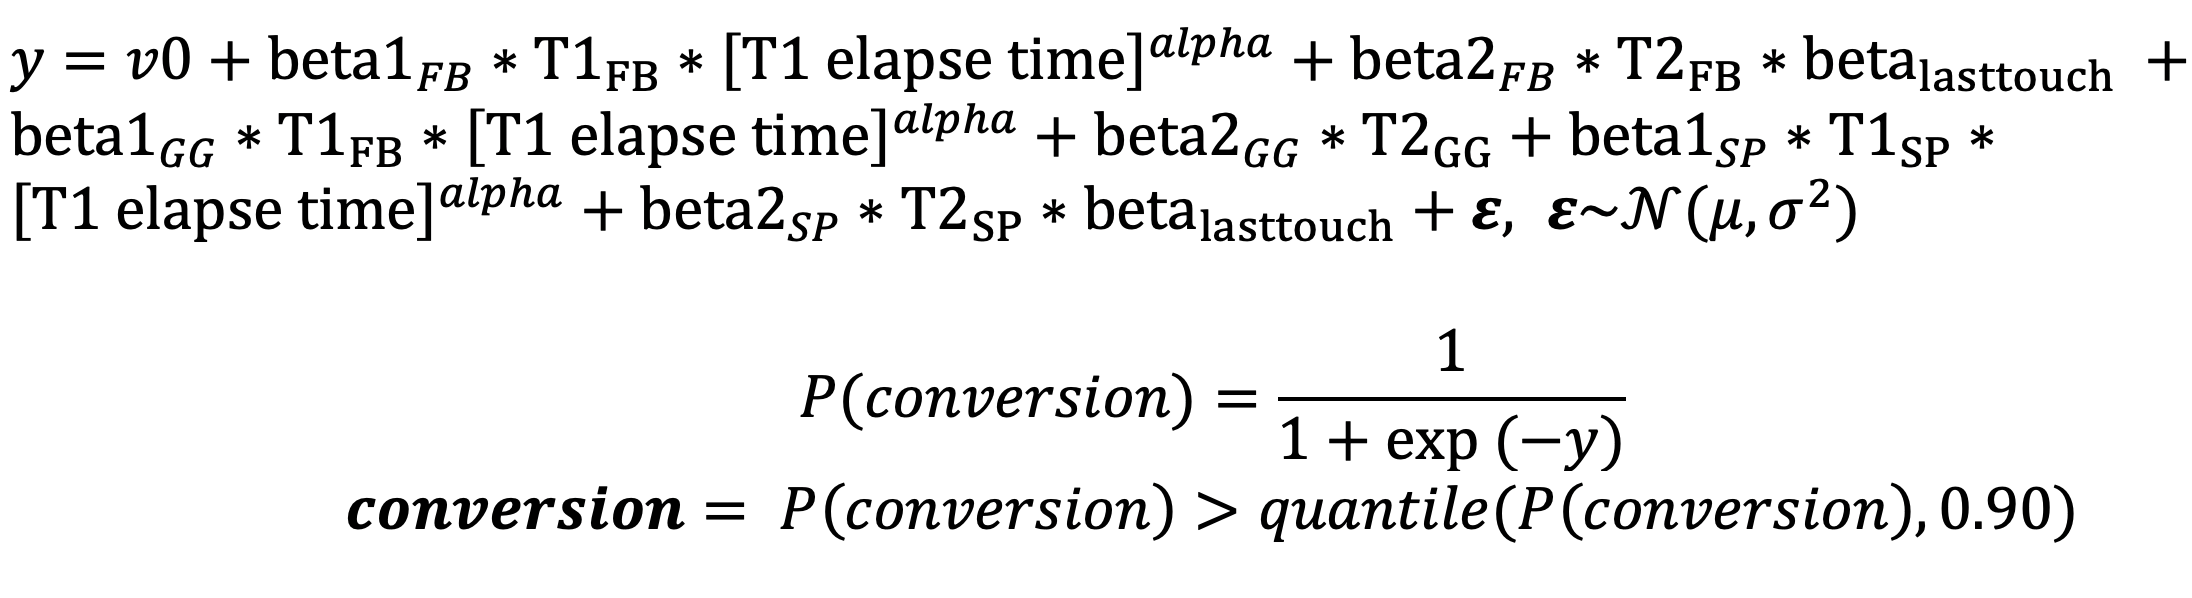

### * It's important to note that the DL model makes no assumptions about the data generating function. This simulation DGP is used simply to generate data with some learnable signal that is partially dependent on the inputs, and from which the "true attributions" can be derived. 

### The generating functions for each of the parameters and inputs were as follows:
 
 - T1_FB, T1_GG, T1_SP, T2_FB, T2_GG, T2_SP ~ unif(1,3)
 - T1_elapse_time ~ gamma(2, 2)
 - gender ~ binomial(0.4)
 - v0 = -3
 - beta1_FB = 0.9
 - beta2_FB = 1.0, 1.8
 - beta1_GG = 1.7
 - beta2_GG = .8
 - beta1_SP = 0.4 , 1.4
 - beta2_SP = 0.5, 1.5
 - beta_lasttouch = .1, .2, .7, 1, 1.5, 2.2
 - beta_lgender = 0.4
 - epsilon ~ Normal(0, 1)



In addition to its interpretability, the functional form of the model and particular parameter values were chosen to loosely simulate a plausible effect wherein Google is more impactful when it is the first impression because it implies higher latent interest (they googled some related terms independently) and the other two channels were either more or less impactful when seen last (depending on the value of beta_lasttouch) to simulate some higher or lower friction to the user purchase flow through their channel (ie: there is a better or worse funnel to purchase at FB than a Google ad).

I chose not to have a boosting effect in T2  for Google just so the model wouldn't be able to learn that T2 is always stronger. It may not be as plausible but it's more interesting to demonstrate that the attention model is actually learning to weight *contextualized* timestep vectors, not just the timesteps themselves.

## Model Description

A detailed description of the model can be found in the paper linked below but the intuition as to how a deep learning model, which are typically black box algorithms, can be used for feature inference is straightforward and outrageously elegant. A time-and-feature contextualized matrix, generated by feeding the touch-point matrix through an embedding and lstm layers, is passed to a multi-layer perceptron (attention layer) which then learns the corresponding weight that it should apply to each of the contextualized vectors of each time step. These weights are linearly interpretable so we can therefore simply add all the weights for a given channel if it appears at multiple touchpoints , or extract its weight as is from the corresponding time step weight if it appears only once. 

The key to understanding the power of this model is that because the attention layer receives a contextualized vector for each time step that has embedded in it a representation of the time-dependent, channel latent-features, and control variable features, it is not simply weighting the importance of each timestep independent of all the vital context - that would produce a rather useless model. Indeed, the model is incorporating all of the signal from the known information (gender, channel, timestep, elapsed time between time steps) to infer the proper amount of weight to give that channel-timestep vector towards predicting a conversion. Of course, it learns to shape these weights by its compulsion to minimize the binary crossentropy, guided by the labels themselves, without which this kind of learning would not be possible.



"Deep Neural Net with Attention for Multi-channel Multi-touch Attribution", Ning li, Sai Kumar Arava, Chen Dong, Zhenyu Yan, Abhishek Pani
https://arxiv.org/abs/1809.02230

## Model Evaluation

Once the model is trained, each input fed into the model will produce a different attention weight vector since that vector output is a function of the static, learned weights AND the transformed input ("attention weights" is a bit of a conflation of terms since they are not static, learned parameters).

The model performance asseessment using the simulations was not "publishably rigorous" as only a few different values for each of the parameters were tested and the distribubtions for the noise, proportion of each channel occurence, and control variable distributions were kept constant. For the attention weights to have any real meaning, however, it was important that the betas for each channel be disernibly different. Interestingly, the DLAW model performance appeared to be U-shaped as the beta that weighted the last-touched (beta_lasttouch) increased from 0 to >2.2. More specifically, DLAW model performance was around 14% MAE at value of beta_lasttouch of 0.2, then got worse to around 19% when beta_lasttouch was 0.7, then went back down to ~12% when beta_lasttouch was 2.2. I believe this shortcoming could be amended by adjusting the architecture or hyperparameters of the model in future iterations.

# Conclusions and Next Steps

### CONCLUSION
This was a very quick and preliminary exploration into the potential of this kind of approach to MTA modeling. The model's performance compared to the naive first/last touched methods was dominant. The 50/50 split model was really used as a marker to indicate when the actual simulated contributions were close to 50/50 so as to ensure the DLAW model can perform well regardless of the underlying contribution distribution. The impressive performance of the DLAW model (in this limited simulation) is therefore its ability to perform well in either scenario, regardless of whether the true attribution was close to 50/50 or not. 
However, to more fully support its viability it would need much more testing in terms of DGP functions, DGP parameter values, noise structure and magnitude, etc. In spite of the sub-rigorous testing, taking into account the success of the authors in implementing this model at Adobe, as well as the viability of the simulated data generating function as, at minimum, a plausible real world DGP, its performance definitely provides sufficient proof to warrant further investigation. 

### NEXT STEPS
As implemented, the model is not to the exact specifications of the model in the paper so perhaps incorporating hierarchical attention and a couple other small differences would help performance even further. Additionally, there may be unintended errors in the implementation of the model in this notebook, so it should be verified whether that is the case. In addition, the data processing portion of the notebook is not scalable to more channels/timesteps/etc, which is an engineering related improvement. Lastly, more robust models should be explored - as was done in the paper - so as to compare how this model fares against stiffer competition than naive models.

## Libraries

In [538]:
from copy import copy
import numpy as np 
from numpy import exp, log
import pandas as pd 
import os

import tensorflow as tf
import keras
from keras.layers import Embedding, Dense, Concatenate, Flatten, Input, Reshape, AdditiveAttention
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#pd.set_option('display.max_colwidth',100)


pd.set_option('display.max_colwidth', -1)

# Simulation Data

### Simulate inputs for 3 channels, constant 2 time steps, 100K observations

In [4]:
channels = ['facebook', 'google', 'snapchat']
num_chnls = len(channels)
N = 100000

np.random.seed(498)
df = pd.DataFrame({'t1':np.random.uniform(-.5,num_chnls-.5,N), 't2':np.random.uniform(0,num_chnls-1,N)})

df['t1'] = df['t1'].apply(lambda x: int(round(x)))
df['t2'] = df['t2'].apply(lambda x: int(round(x)))

np.random.seed(1)
df['gap1'] = np.random.gamma(2, 2, N)
np.random.seed(3)
df['gender'] = np.random.binomial(1, .4, N)


### Parameter Assignment

In [574]:

v0 = -3 #intercept, negative since most people don't convert
beta_g0 = 1.7 #google effect when it is first time step is stronger than otherwise
beta_g1 = .8 #google effect when it is second time step
beta_f0 = .9 #facebook effect when it is first time step 
beta_f1 = 1.8 #facebook effect when it is second time step
beta_s0 = 1.4 #snapchat effect when it is first time step
beta_s1 = 1.5 #snapchat effect when it is first time step
beta_last_tch = 1.5 #effect boosted when channel is last touched, constant for all channels
beta_gender = .4 #effect for gender 
alpha = -.1 #decay effect for gap between time steps, constant for all channels

#Error term
#np.random.seed(123)
epsilon = np.random.normal(0, 1, len(df))


### Logistic Data Generating Function

In [575]:

y = v0 + beta_f0*(df['t1']==0)*df['gap1'].apply(lambda x: x**alpha) + beta_f1*(df['t2']==0)*beta_last_tch +\
beta_g0*(df['t1']==1)*df['gap1'].apply(lambda x: x**alpha) + beta_g1*(df['t2']==1) +\
beta_s0*(df['t1']==2)*df['gap1'].apply(lambda x: x**alpha) + beta_s1*(df['t2']==2)*beta_last_tch +\
beta_gender*df['gender']\
+ epsilon

z = 1/(1+exp(-y))

In [576]:
df['y'] = y 
df['z'] = z 
df['epsilon'] = epsilon

# Conversion for only top 10% of users 
df['conversion'] = df['z']>=np.quantile(df['z'], .9)
df['conversion']= df['conversion'].astype(int)


#### Distribution of P(conversion) and **conversion**

(array([ 5857., 10908., 11439., 11191., 10840., 10800., 11064., 11252.,
        10831.,  5818.]),
 array([0.00672275, 0.10556201, 0.20440126, 0.30324052, 0.40207977,
        0.50091903, 0.59975828, 0.69859753, 0.79743679, 0.89627604,
        0.9951153 ]),
 <a list of 10 Patch objects>)

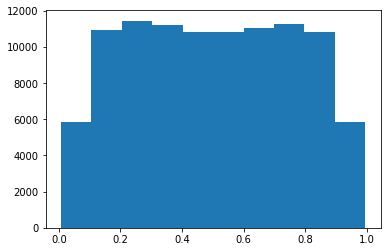

In [577]:
plt.hist(df['z'])


(array([90000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

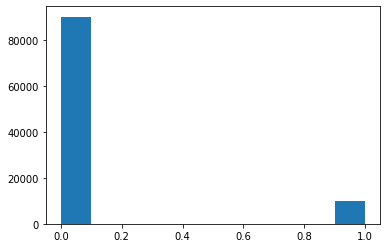

In [578]:
plt.hist(df['conversion'])


#### Create columns for the calculated contribution of each channel

In [579]:

df['cont_unscaled_fb'] = beta_f0*(df['t1']==0)*df['gap1'].apply(lambda x: x**alpha) + beta_f1*(df['t2']==0)*beta_last_tch

df['cont_unscaled_gg'] = beta_g0*(df['t1']==1)*df['gap1'].apply(lambda x: x**alpha) + beta_g1*(df['t2']==1) 
    
df['cont_unscaled_sp'] = beta_s0*(df['t1']==2)*df['gap1'].apply(lambda x: x**alpha) + beta_s1*(df['t2']==2)*beta_last_tch

df['cont_fb'] = df['cont_unscaled_fb']/(df['cont_unscaled_fb'] + df['cont_unscaled_gg'] + df['cont_unscaled_sp'])
df['cont_gg'] = df['cont_unscaled_gg']/(df['cont_unscaled_fb'] + df['cont_unscaled_gg'] + df['cont_unscaled_sp'])
df['cont_sp'] = df['cont_unscaled_sp']/(df['cont_unscaled_fb'] + df['cont_unscaled_gg'] + df['cont_unscaled_sp'])


#### View of sample of the dataframe

In [580]:
df[['t1', 't2', 'gap1', 'gender','y','z','epsilon', 'conversion', 'cont_unscaled_fb','cont_unscaled_gg','cont_unscaled_sp', 'cont_fb', 'cont_gg', 'cont_sp']].sample(10)


,t1,t2,gap1,gender,y,z,epsilon,conversion,cont_unscaled_fb,cont_unscaled_gg,cont_unscaled_sp,cont_fb,cont_gg,cont_sp
68238,0,1,0.813115,1,-2.303631,0.090823,-1.422445,0,0.918813,0.800000,0.000000,0.534563,0.465437,0.000000
95849,2,1,2.393590,1,0.364525,0.590135,0.881535,0,0.000000,0.800000,1.282989,0.000000,0.384063,0.615937
90507,1,1,5.718785,1,-2.007892,0.118377,-1.635860,0,0.000000,2.227968,0.000000,0.000000,1.000000,0.000000
10967,2,1,2.194000,0,-0.968165,0.275246,-0.062374,0,0.000000,0.800000,1.294209,0.000000,0.382006,0.617994
97735,1,2,0.933398,0,0.692456,0.666513,-0.269301,0,0.000000,1.711757,2.250000,0.000000,0.432070,0.567930
53107,2,0,1.486974,0,1.181414,0.765202,0.135871,0,2.700000,0.000000,1.345543,0.667401,0.000000,0.332599
39275,2,1,0.083071,1,-0.749012,0.321037,-0.744502,0,0.000000,0.800000,1.795490,0.000000,0.308227,0.691773
69223,2,1,4.046924,0,-1.235730,0.225180,-0.253080,0,0.000000,0.800000,1.217350,0.000000,0.396560,0.603440
44524,2,2,5.092283,0,-0.539896,0.368212,-0.979594,0,0.000000,0.000000,3.439698,0.000000,0.000000,1.000000
12349,1,1,1.428686,0,-1.542857,0.176120,-0.983278,0,0.000000,2.440421,0.000000,0.000000,1.000000,0.000000


#### Distribution of epsilon for conversion==1
###### P(epsilon | conversion=1) has a higher mean than P(epsilon | conversion=0), as expected

(array([ 105.,  889., 2247., 2731., 2042., 1069.,  572.,  258.,   66.,
          21.]),
 array([-0.20473648,  0.20454281,  0.61382209,  1.02310138,  1.43238066,
         1.84165995,  2.25093923,  2.66021852,  3.06949781,  3.47877709,
         3.88805638]),
 <a list of 10 Patch objects>)

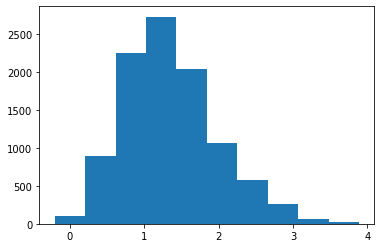

In [581]:
plt.hist(df[df['conversion']==1]['epsilon'])

#### Distribution of epsilon for conversion==0
###### P(epsilon | conversion=0) has a lower mean than P(epsilon | conversion=1), as expected

(array([   29.,   296.,  2064.,  8373., 19581., 28136., 21597.,  7935.,
         1821.,   168.]),
 array([-4.18321918, -3.44970844, -2.7161977 , -1.98268696, -1.24917622,
        -0.51566548,  0.21784526,  0.951356  ,  1.68486674,  2.41837748,
         3.15188822]),
 <a list of 10 Patch objects>)

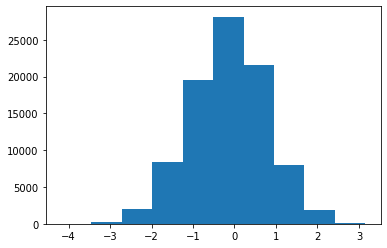

In [582]:
plt.hist(df[df['conversion']==0]['epsilon'])

## Format Data for Input

In [583]:
num_time_steps = 2
num_cats = 3
num_feats = 2

### Train Test Split / Split into Numerical and Categorical Matrices / Reshape 

df['gap1_t2'] = 0 #create an extra gap column for time step 2 which is always 0 since there is no time step 3 in this simulation
X = df[['t1', 't2','gender', 'gap1','gender_t2', 'gap1_t2', 'epsilon']]
y = np.array(df['conversion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

#Split X_train into numerical and categorical matrices for separate input into the model
X_train_num = np.array(X_train[['gender', 'gap1', 'gender','gap1_t2']]) #gender is time-invariant so the same for both time steps
X_test_num = np.array(X_test[['gender', 'gap1', 'gender_t2','gap1_t2']])
X_train_num2 = np.reshape(X_train_num, (len(X_train_num),num_time_steps, num_feats))
X_test_num2 = np.reshape(X_test_num, (len(X_test_num),num_time_steps, num_feats))
X_train_cat = X_train[['t1', 't2']]
X_train_cat2 = np.reshape(np.array(X_train_cat), (len(X_train_cat),num_time_steps , 1))
X_test_cat = X_test[['t1', 't2']]
X_test_cat2 = np.reshape(np.array(X_test_cat), (len(X_test_cat), num_time_steps , 1))
print(X_train_cat2.shape)
print(X_train_num2.shape)
print(X_test_cat2.shape)
print(X_test_num2.shape)
print(y_train.shape)
print(y_test.shape)


#### View sample of X_train_num2 

In [584]:
X_train_num2[:3]

array([[[0.        , 3.73745316],
        [0.        , 0.        ]],

       [[0.        , 5.98632315],
        [0.        , 0.        ]],

       [[0.        , 2.29993883],
        [0.        , 0.        ]]])

#### Verify X_train_cat2 is tokenized

In [585]:
X_train_cat2[:3]

array([[[0],
        [1]],

       [[1],
        [2]],

       [[0],
        [2]]])

## Deep Learning Model Construction

In [586]:
from keras import backend as K

class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.w=self.add_weight(shape=(128, units), initializer="normal")
        self.b=self.add_weight(shape=(2, units), initializer="zeros")
        
       # self.w2=self.add_weight(shape=(256, 1), initializer="normal")
        #self.b2=self.add_weight(shape=(2, 1), initializer="zeros")

    def call(self, x):

        e1 = K.relu(K.dot(x,self.w)+self.b)
      #  e2 = K.relu(K.dot(e1,self.w2)+self.b2)

        a = K.softmax(e1, axis=1)
        #a = [e1[0][0]/(e1[0][0]+e1[1][0]), e1[1][0]/(e1[0][0]+e1[1][0])]
        output = a*x
        
        return e1, K.sum(output, axis=1)

In [587]:
embedding_size = 2 #dimensionality of embedding vector
cardinality = len(channels) # cardinality of the categorical feature (channel)


inp_cat_data = Input(shape=(num_time_steps, 1)) #input for categorical data
inp_num_data = Input(shape=(num_time_steps, num_feats)) #input for numerical data

emb = Embedding(cardinality, embedding_size, input_length=(num_time_steps))(inp_cat_data) #Embedding layer for categorical data (channels)

resh1 = Reshape((num_time_steps, embedding_size))(emb) #reshape to squash the 4D tensor back into 3D, not sure why emb layer does this

conc = Concatenate()([resh1, inp_num_data]) #combine numerical data with channel embedding tensor before inputting into LSTM

resh2 = Reshape((num_time_steps, embedding_size+num_feats))(conc) #reshape to fit LSTM needs just in case
# LSTM with channel embeddings and control features, returns hidden state sequences for the attention layer to use
lstm_layer = LSTM(128, dropout=.03, recurrent_dropout=.03,return_sequences=True)(resh2)

#Attention layer: multi-layer perceptron with 1 neuron, returns unscaled attention weight vector and attention weighted sum
a_unsc, attention_layer = Attention(1)(lstm_layer)


#Output layer dense, binary outcome
out = Dense(1, activation='sigmoid')(attention_layer)

#output the prediction and the unscaled attention to retrieve after training - not sure if this screws up the training of any layers
model = keras.Model(inputs=[inp_cat_data, inp_num_data], outputs=[out, a_unsc] )
#model = keras.Model(inputs=[inp_cat_data, inp_num_data], outputs=out )

model.compile(optimizer=Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['acc'])

In [588]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 2, 1)]       0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 2, 1, 2)      6           input_31[0][0]                   
__________________________________________________________________________________________________
reshape_30 (Reshape)            (None, 2, 2)         0           embedding_15[0][0]               
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 2, 2)]       0                                            
___________________________________________________________________________________________

### Run Model until loss stops improving

In [589]:
epochs = 10
batch_size = 100
model.fit(x=[X_train_cat2, X_train_num2], y=y_train, validation_data=([X_test_cat2, X_test_num2], y_test), epochs=epochs, batch_size=batch_size)


Epoch 1/10
700/700 [==============================] - 7s 7ms/step - loss: 0.7013 - dense_15_loss: 0.3787 - attention_15_loss: 0.3225 - dense_15_acc: 0.9015 - attention_15_acc: 0.9016 - val_loss: 0.5178 - val_dense_15_loss: 0.2373 - val_attention_15_loss: 0.2805 - val_dense_15_acc: 0.8989 - val_attention_15_acc: 0.8989
Epoch 2/10
700/700 [==============================] - 4s 6ms/step - loss: 0.4961 - dense_15_loss: 0.2168 - attention_15_loss: 0.2792 - dense_15_acc: 0.9056 - attention_15_acc: 0.9020 - val_loss: 0.4846 - val_dense_15_loss: 0.2059 - val_attention_15_loss: 0.2787 - val_dense_15_acc: 0.9091 - val_attention_15_acc: 0.9033
Epoch 3/10
700/700 [==============================] - 4s 6ms/step - loss: 0.4816 - dense_15_loss: 0.2029 - attention_15_loss: 0.2787 - dense_15_acc: 0.9117 - attention_15_acc: 0.9032 - val_loss: 0.4917 - val_dense_15_loss: 0.2064 - val_attention_15_loss: 0.2853 - val_dense_15_acc: 0.9086 - val_attention_15_acc: 0.8989
Epoch 4/10
700/700 [====================

KeyboardInterrupt: 

# Model Evaluation

#### Extract prediction probabilities and unscaled attention weight vectors (e1) for observations in X_test

In [590]:
preds, a = model.predict(x=[X_test_cat2, X_test_num2])

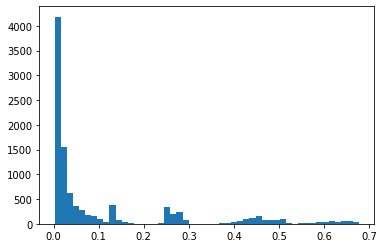

In [591]:
#preds = pd.DataFrame(model.predict([X_train_cat2, X_train_num2]))
preds = pd.DataFrame(preds)
preds.rename(columns={0:'pred_prob'}, inplace=True)
_=plt.hist(preds['pred_prob'].sample(10000), bins=50)

#### Use the conversion balance of the training set to find a reasonable prediction threshold

In [592]:
thresh = np.quantile(preds['pred_prob'], (1-y_train.mean()))
thresh

0.4342219087643283

#### Extract attention weights from their awkward data structure and put them in a dataframe

In [593]:

a2 = []
for i in range(len(a)):
    a2.append( [a[i][0][0], a[i][1][0]])
a2_df = pd.DataFrame(a2, columns=['t1_attn_unscaled', 't2_attn_unscaled'])

#### Combine original input features, target, actual channel contributions, predictions, and estimated channel attentions in one convenient dataframe

In [594]:

preds_df = pd.concat([preds, pd.DataFrame(y_test)], axis=1)
preds_df.rename(columns={0:'actual'}, inplace=True)
preds_df.reset_index(drop=True,inplace=True)
preds_df['pred'] = preds_df['pred_prob']>thresh
preds_df2 = pd.concat([pd.DataFrame(X_test).reset_index(), preds_df], axis=1)
preds_df2 = pd.concat([preds_df2, a2_df], axis=1)
preds_df3 = preds_df2.merge(df[['t1', 't2', 'gender', 'gap1','cont_fb','cont_gg','cont_sp' ]], 'left', on=['t1', 't2', 'gender', 'gap1'])

preds_df3['t1_attn'] = preds_df3['t1_attn_unscaled']/(preds_df3['t1_attn_unscaled']+preds_df3['t2_attn_unscaled'])
preds_df3['t2_attn'] = preds_df3['t2_attn_unscaled']/(preds_df3['t1_attn_unscaled']+preds_df3['t2_attn_unscaled'])



#### Functions for getting the contribution for the timestep to compare directly to attention weights

In [595]:
def get_t1_cont(row):
    t1_cont = 0

    if row['t1']==0:
        t1_cont = row['cont_fb']
    elif row['t1']==1:
        t1_cont = row['cont_gg']
    else:
        t1_cont = row['cont_sp']

    return t1_cont

def get_t2_cont(row):
    t2_cont = 0

    if row['t2']==0:
        t2_cont = row['cont_fb']
    elif row['t2']==1:
        t2_cont = row['cont_gg']
    else:
        t2_cont = row['cont_sp']

    return t2_cont

In [596]:
preds_df3['t1_cont'] = preds_df3.apply(get_t1_cont, axis=1)
preds_df3['t2_cont'] = preds_df3.apply(get_t2_cont, axis=1)

#### Preview a sample of estimated attention (t1_attn, t2_atten) *vs.* actual contribution (t1_cont, t2_cont)

In [597]:
preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])][['t1', 't2', 't1_cont', 't2_cont', 't1_attn', 't2_attn']].sample(10)


,t1,t2,t1_cont,t2_cont,t1_attn,t2_attn
20027,1,0,0.334780,0.665220,0.270533,0.729467
3513,1,0,0.361531,0.638469,0.286078,0.713922
27758,1,0,0.364001,0.635999,0.297278,0.702722
600,1,0,0.351845,0.648155,0.283260,0.716740
10692,1,0,0.359924,0.640076,0.285657,0.714343
1284,1,0,0.358978,0.641022,0.285405,0.714595
13521,1,0,0.389489,0.610511,0.294859,0.705141
17237,1,0,0.367956,0.632044,0.298765,0.701235
2990,1,0,0.359758,0.640242,0.285613,0.714387
24106,0,2,0.283011,0.716989,0.381484,0.618516


In [598]:
### Calculate residuals for the DLAW model and 3 naive models: 50/50 split, last touched, and first touched

In [599]:
preds_df3['cont_error'] = preds_df3['t1_cont']-preds_df3['t1_attn']
preds_df3['5050_cont_error'] = preds_df3['t1_cont']-.5
preds_df3['last_touch_cont_error'] = 1-preds_df3['t2_cont']
preds_df3['first_touch_cont_error'] = 1-preds_df3['t1_cont']


### Calculate MAE only for observations with:
 - actual conversion==1: we only care about attributing people who converted
 - t1 channel does not equal t2 channel: there is no uncertainty of attribution in cases where t1 channel==t2 channel
 - predicted probability >0.03: These are likely noisier since the model found no signal for conversion. This was chosen arbitrarily ahead of time and does not change for each run

In [600]:
min_p = .03

In [601]:
dlaw_mae = preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['cont_error'].apply(lambda x: abs(x)).mean()
dlaw_medae = preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['cont_error'].apply(lambda x: abs(x)).median()
dlaw_err_sd = preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['cont_error'].apply(lambda x: abs(x)).std()
dlaw_95CI = dlaw_mae+(1.64*dlaw_err_sd)

even_split_mae = preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['5050_cont_error'].apply(lambda x: abs(x)).mean()
even_split_medae = preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['5050_cont_error'].apply(lambda x: abs(x)).median()
even_split_err_sd = preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['5050_cont_error'].apply(lambda x: abs(x)).std()
even_split_95CI = even_split_mae+(1.64*even_split_err_sd)


lt_mae = preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['last_touch_cont_error'].apply(lambda x: abs(x)).mean()
lt_medae = preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['last_touch_cont_error'].apply(lambda x: abs(x)).median()
lt_err_sd = preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['last_touch_cont_error'].apply(lambda x: abs(x)).std()
lt_95CI = lt_mae+(1.64*lt_err_sd)


ft_mae = preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['first_touch_cont_error'].apply(lambda x: abs(x)).mean()
ft_medae = preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['first_touch_cont_error'].apply(lambda x: abs(x)).median()
ft_err_sd = preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['first_touch_cont_error'].apply(lambda x: abs(x)).std()
ft_95CI = ft_mae+(1.64*ft_err_sd)




print('DLAW Stats:\n', 'Mean AE:', round(dlaw_mae, 3), ', Median AE', round(dlaw_medae, 3), '95% CI Error:', round(dlaw_95CI, 3))
print('\n50/50 Split Stats:\n', 'Mean AE:', round(even_split_mae, 3), ', Median AE', round(even_split_medae, 3), '95% CI Error:', round(even_split_95CI, 3))
print('\nLast Touched Stats:\n', 'Mean AE:', round(lt_mae, 3), ', Median AE', round(lt_medae, 3), '95% CI Error:', round(lt_95CI, 3))
print('\nFirst Touched Stats:\n', 'Mean AE:', round(ft_mae, 3), ', Median AE', round(ft_medae, 3), '95% CI Error:', round(ft_95CI, 3))




DLAW Stats:
 Mean AE: 0.072 , Median AE 0.066 95% CI Error: 0.127

50/50 Split Stats:
 Mean AE: 0.145 , Median AE 0.145 95% CI Error: 0.193

Last Touched Stats:
 Mean AE: 0.355 , Median AE 0.355 95% CI Error: 0.403

First Touched Stats:
 Mean AE: 0.645 , Median AE 0.645 95% CI Error: 0.693


#### DLAW Distribution of Residuals

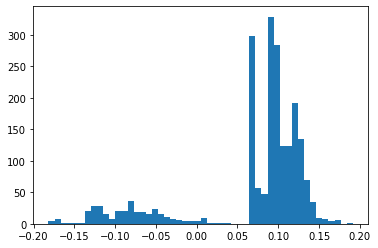

In [467]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['cont_error'], bins=50)


#### 50/50 Split Distribution of Residuals

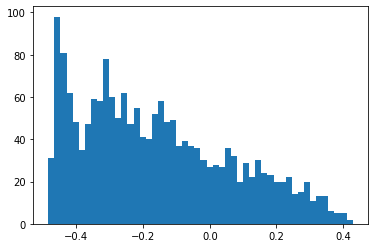

In [125]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['5050_cont_error'], bins=50)


#### Last Touched Distribution of Residuals

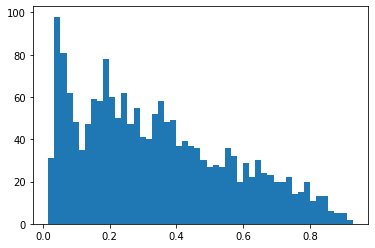

In [126]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['last_touch_cont_error'], bins=50)


#### First Touched Distribution of Residuals

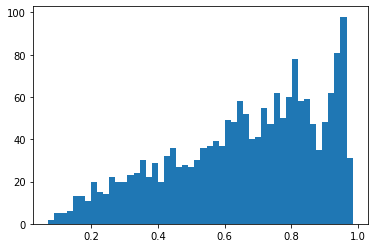

In [127]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['first_touch_cont_error'], bins=50)


## Impact of Noise on the Model

### Distribution of error in False Positives is left skewed as expected. 
##### The model made the right inference of "Likely Conversion" based solely on the inputs available to it onaverage,but was screwed from the get go due to the large, negative error that ended up with the majority of impact in determining the actual conversion status

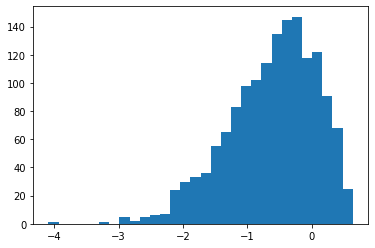

In [131]:
_=plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==True)]['epsilon'], bins=30)

### Distribution of error in True Positives is more symmetrical and centered closer to zero


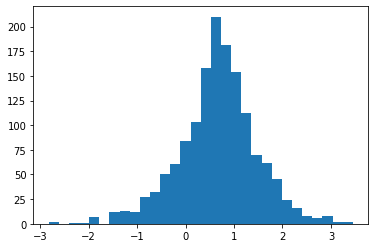

In [134]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==True)]['epsilon'], bins=30)

### Distribution of error in False Negatives is right skewed as expected


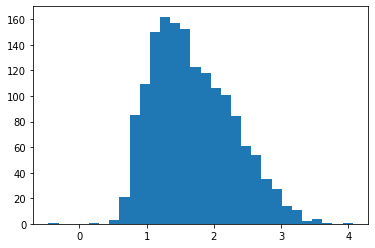

In [133]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['epsilon'], bins=30)

### Distribution of error in True Negatives is more symmetrical and centered closer to zero


(array([1.000e+00, 0.000e+00, 2.000e+00, 5.000e+00, 6.000e+00, 1.300e+01,
        3.000e+01, 5.200e+01, 8.500e+01, 1.600e+02, 2.410e+02, 4.020e+02,
        5.940e+02, 8.130e+02, 1.017e+03, 1.366e+03, 1.619e+03, 1.853e+03,
        1.916e+03, 2.050e+03, 2.030e+03, 1.866e+03, 1.632e+03, 1.364e+03,
        1.187e+03, 7.830e+02, 4.900e+02, 1.980e+02, 4.300e+01, 1.600e+01]),
 array([-4.40693411, -4.18301038, -3.95908665, -3.73516292, -3.51123919,
        -3.28731547, -3.06339174, -2.83946801, -2.61554428, -2.39162055,
        -2.16769682, -1.94377309, -1.71984937, -1.49592564, -1.27200191,
        -1.04807818, -0.82415445, -0.60023072, -0.37630699, -0.15238326,
         0.07154046,  0.29546419,  0.51938792,  0.74331165,  0.96723538,
         1.19115911,  1.41508284,  1.63900656,  1.86293029,  2.08685402,
         2.31077775]),
 <a list of 30 Patch objects>)

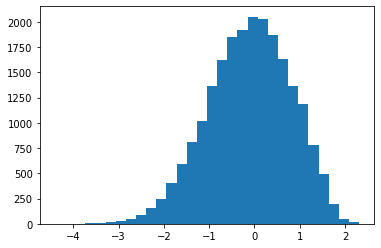

In [1811]:
plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==False)]['epsilon'], bins=30)

### In the cases of False Positive and False Negative: the model made the right inference of "Likely Conversion" or "Unlikely Conversion", respectively, based solely on the inputs available to it on average.
### However it was screwed from the get go due to the large, negative or positive error, respectively, that ended up with the majority of impact in determining the actual conversion status

# Accuracy of Y Prediction
### *This is secondary to the main purpose of the model which is to learn attribution percentages, and is mostly unimportant given the simplicity of the DGP in the simulation. However, a model with better performance is more likely to specify the parameters correctly so improving the prediction accuracy can be expected to improve attribution accuracy as well.

In [137]:
conf = confusion_matrix(preds_df2['actual'], preds_df2['pred'])
conf = pd.DataFrame(conf)
conf.rename(columns={0:'pred_False', 1:'pred_True'}, inplace=True)
print('Test Accuracy:', accuracy_score(preds_df2['actual'], preds_df2['pred']))
conf

Test Accuracy: 0.8966333333333333


,pred_False,pred_True
0,25436,1518
1,1583,1463


## Error Distributions Correlations with Features

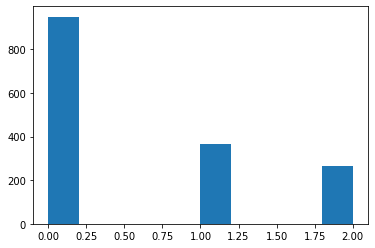

In [140]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['t2'])

### False positives appear to be worse for Google (1) in T1 and Facebook (0) in T2

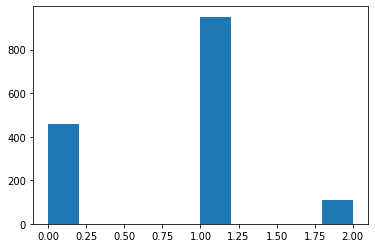

In [121]:
_=plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==True)]['t1'])

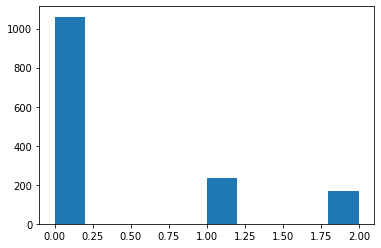

In [138]:
_=plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==True)]['t2'])

### False Negatives appear to be worse for Facebook (0) in T2

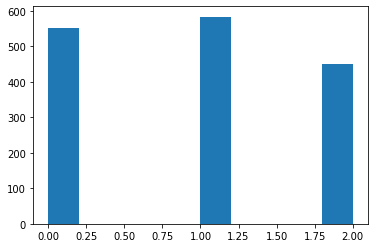

In [142]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['t1'])

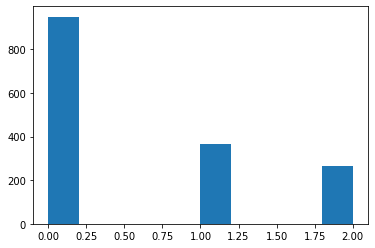

In [143]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['t2'])

### Elapsed time (gap1) distribution for False Negative

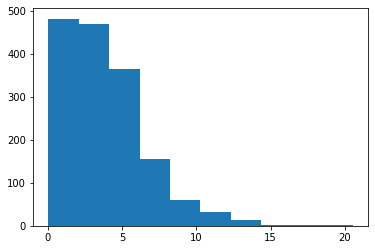

In [123]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['gap1'])

### Elapsed time (gap1) distribution for False Positive

(array([189., 359., 185., 172., 215., 152., 104.,  55.,  45.,  42.]),
 array([0.12472287, 0.61032124, 1.0959196 , 1.58151797, 2.06711634,
        2.5527147 , 3.03831307, 3.52391144, 4.00950981, 4.49510817,
        4.98070654]),
 <a list of 10 Patch objects>)

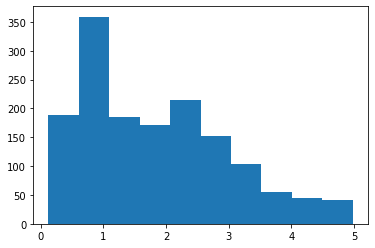

In [141]:
plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==True)]['gap1'])
